In [34]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import io

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, MinMaxScaler, RobustScaler, MaxAbsScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Import Gradient Boosting Models
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
# Set a professional and consistent aesthetic for plots
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("pastel")

In [36]:
# --- 1. Load the Dataset ---
try:
    df = pd.read_csv('Test_data.csv')
    print("Dataset loaded successfully from 'Test_data.csv'.")
except FileNotFoundError:
    print("Test_data.csv not found. Please ensure the file is in the correct directory.")
    # Fallback: Dummy DataFrame for demonstration if file is not found
    data = """
Age,Gender,Department,YearsAtCompany,PerformanceRating,SatisfactionLevel,TrainingCompleted,PromotionLastYear
30,Male,Sales,5,Good,8,Yes,No
25,Female,Marketing,2,Average,6,No,No
35,Male,HR,10,Excellent,9,Yes,Yes
28,Female,Sales,3,Good,7,Yes,No
40,Male,IT,15,Excellent,9,Yes,Yes
22,Female,Marketing,1,Average,5,No,No
33,Male,HR,7,Good,8,Yes,No
29,Female,IT,4,Average,6,No,No
31,Male,Sales,6,Good,8,Yes,No
26,Female,Marketing,2,Average,6,No,No
38,Male,HR,12,Excellent,9,Yes,Yes
27,Female,Sales,3,Good,7,Yes,No
"""
    df = pd.read_csv(io.StringIO(data))
    print("Loaded a dummy dataset for demonstration purposes.")
    print("Note: With an extremely small dataset like this dummy data (12 rows), model performance metrics")
    print("      can be highly variable and may show perfect accuracy due to overfitting or lack of diversity.")
    print("      Results should be interpreted with caution and are primarily for demonstrating the workflow.")
    print("      The 'fixes' for LightGBM warnings in this code allow it to train on minimal data,")
    print("      but do not make the model perform robustly or generalize well.")



Test_data.csv not found. Please ensure the file is in the correct directory.
Loaded a dummy dataset for demonstration purposes.
Note: With an extremely small dataset like this dummy data (12 rows), model performance metrics
      can be highly variable and may show perfect accuracy due to overfitting or lack of diversity.
      Results should be interpreted with caution and are primarily for demonstrating the workflow.
      The 'fixes' for LightGBM warnings in this code allow it to train on minimal data,
      but do not make the model perform robustly or generalize well.


In [38]:
# --- 2. Initial Data Exploration ---
print("\n--- Dataset Information ---")
df.info()

print("\n--- First 5 Rows of the Dataset ---")
print(df.head())

print("\n--- Basic Statistical Summary ---")
print(df.describe(include='all'))

print("\n--- Missing Values Check ---")
print(df.isnull().sum())



--- Dataset Information ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12 entries, 0 to 11
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Age                12 non-null     int64 
 1   Gender             12 non-null     object
 2   Department         12 non-null     object
 3   YearsAtCompany     12 non-null     int64 
 4   PerformanceRating  12 non-null     object
 5   SatisfactionLevel  12 non-null     int64 
 6   TrainingCompleted  12 non-null     object
 7   PromotionLastYear  12 non-null     object
dtypes: int64(3), object(5)
memory usage: 900.0+ bytes

--- First 5 Rows of the Dataset ---
   Age  Gender Department  YearsAtCompany PerformanceRating  \
0   30    Male      Sales               5              Good   
1   25  Female  Marketing               2           Average   
2   35    Male         HR              10         Excellent   
3   28  Female      Sales               3              

In [40]:
# --- 3. Identify Categorical Features for Visualization ---
categorical_features_for_plot = df.select_dtypes(include=['object', 'category']).columns.tolist()
if 'PerformanceRating' not in categorical_features_for_plot and 'PerformanceRating' in df.columns:
    if df['PerformanceRating'].nunique() < 10:
        categorical_features_for_plot.append('PerformanceRating')

if 'PerformanceRating' in df.columns:
    performance_order = ['Poor', 'Average', 'Good', 'Excellent']
    df['PerformanceRating'] = pd.Categorical(df['PerformanceRating'], categories=performance_order, ordered=True)

print(f"\n--- Identified Categorical Features for Visualization: {categorical_features_for_plot} ---")




--- Identified Categorical Features for Visualization: ['Gender', 'Department', 'PerformanceRating', 'TrainingCompleted', 'PromotionLastYear'] ---



--- Generating Count Plots ---


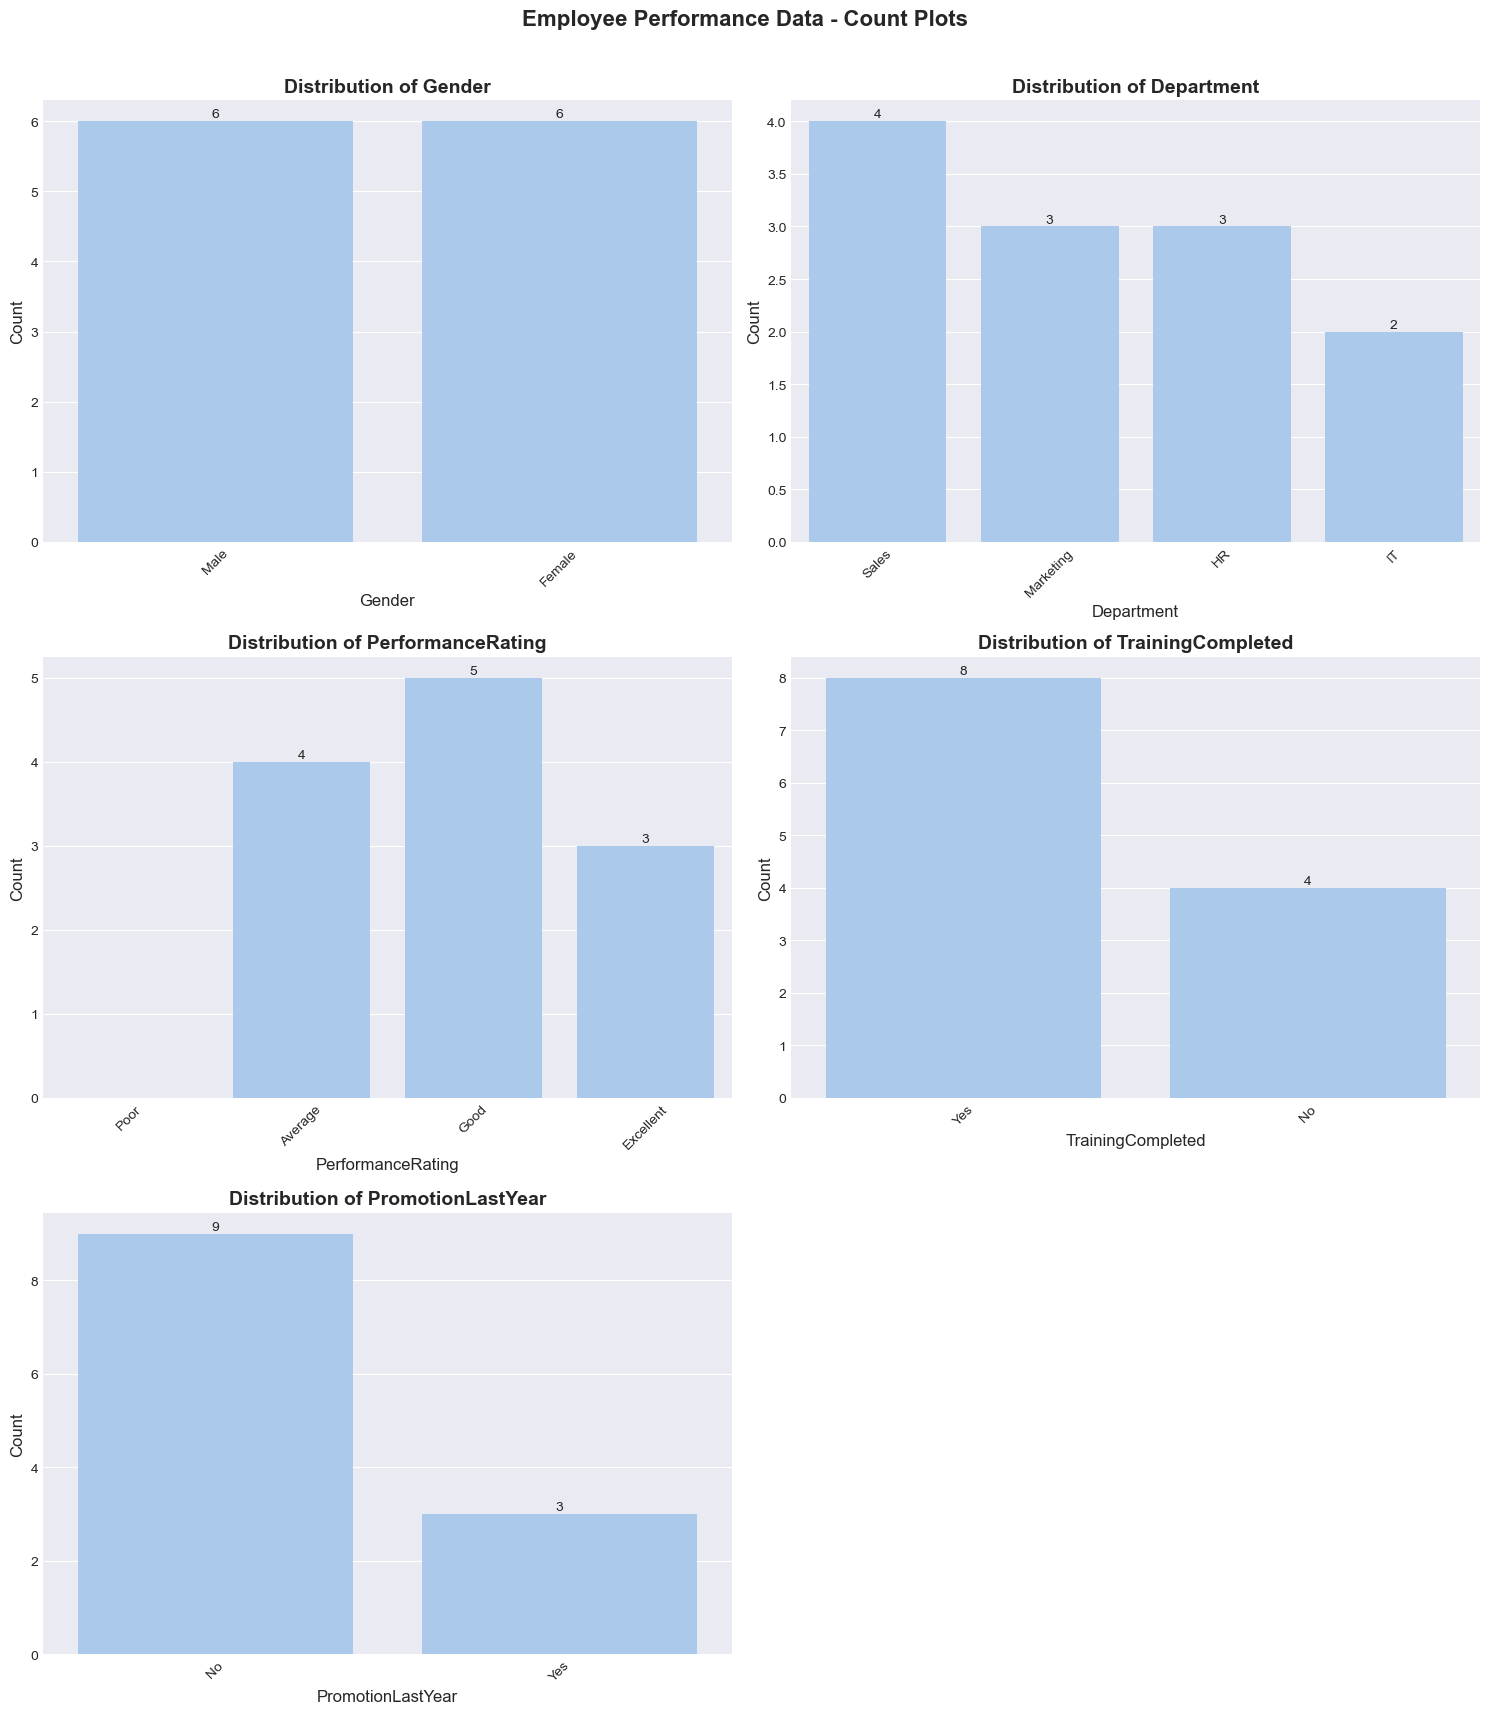

In [42]:
# --- 4. Generate Count Plots for Categorical Features ---
print("\n--- Generating Count Plots ---")

num_features_plot = len(categorical_features_for_plot)
if num_features_plot == 0:
    print("No categorical features found to plot count plots for.")
else:
    n_cols_plot = 2
    n_rows_plot = (num_features_plot + n_cols_plot - 1) // n_cols_plot

    fig, axes = plt.subplots(n_rows_plot, n_cols_plot, figsize=(15, 6 * n_rows_plot))
    axes = axes.flatten()

    for i, feature in enumerate(categorical_features_for_plot):
        ax = axes[i]
        if feature == 'PerformanceRating':
            sns.countplot(data=df, x=feature, ax=ax, order=df[feature].cat.categories)
        else:
            sns.countplot(data=df, x=feature, ax=ax, order=df[feature].value_counts().index)

        ax.set_title(f'Distribution of {feature}', fontsize=14, fontweight='bold')
        ax.set_xlabel(feature, fontsize=12)
        ax.set_ylabel('Count', fontsize=12)
        ax.tick_params(axis='x', rotation=45)

        for p in ax.patches:
            ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()),
                        ha='center', va='center', xytext=(0, 5), textcoords='offset points', fontsize=10)

    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    fig.suptitle('Employee Performance Data - Count Plots', fontsize=16, fontweight='bold', y=0.98)
    plt.show()

In [44]:
# --- 5. Identify Unique Values and Their Counts ---
print("\n--- Unique Values and Their Counts for Categorical Features ---")
for feature in categorical_features_for_plot:
    print(f"\nFeature: '{feature}'")
    unique_counts = df[feature].value_counts()
    print(unique_counts)
    print("-" * 30)




--- Unique Values and Their Counts for Categorical Features ---

Feature: 'Gender'
Gender
Male      6
Female    6
Name: count, dtype: int64
------------------------------

Feature: 'Department'
Department
Sales        4
Marketing    3
HR           3
IT           2
Name: count, dtype: int64
------------------------------

Feature: 'PerformanceRating'
PerformanceRating
Good         5
Average      4
Excellent    3
Poor         0
Name: count, dtype: int64
------------------------------

Feature: 'TrainingCompleted'
TrainingCompleted
Yes    8
No     4
Name: count, dtype: int64
------------------------------

Feature: 'PromotionLastYear'
PromotionLastYear
No     9
Yes    3
Name: count, dtype: int64
------------------------------


In [46]:
# --- 6. Infer Trends and Insights from Data Visualization ---
print("\n--- Key Trends and Insights from Data Visualization ---")
if 'PerformanceRating' in df.columns:
    print("\n**Performance Rating Distribution:**")
    print(f"The most common performance rating is '{df['PerformanceRating'].mode()[0]}'.")
    print(f"There are {df['PerformanceRating'].value_counts().get('Excellent', 0)} employees with 'Excellent' performance, "
          f"and {df['PerformanceRating'].value_counts().get('Poor', 0)} with 'Poor' performance.")

if 'Department' in df.columns:
    print("\n**Departmental Insights:**")
    print(f"The '{df['Department'].mode()[0]}' department appears to have the highest number of employees in this dataset.")

if 'YearsAtCompany' in df.columns:
    print("\n**Years at Company vs. Performance (Initial Observation):**")
    if df['YearsAtCompany'].nunique() < 20:
        print(f"A significant portion of employees have been with the company for around {df['YearsAtCompany'].mode()[0]} years.")

if 'Gender' in df.columns:
    print("\n**Gender Distribution:**")
    print(f"The dataset shows a distribution of genders, with '{df['Gender'].mode()[0]}' being more prevalent.")

if 'TrainingCompleted' in df.columns:
    print("\n**Training Completion Impact (Hypothesis):**")
    print(f"A majority of employees have '{df['TrainingCompleted'].mode()[0]}' training completed. "
          "This suggests training might be a common practice or a factor to investigate for its correlation with performance.")

if 'PromotionLastYear' in df.columns:
    print("\n**Promotion Trends:**")
    print(f"Most employees in the dataset '{df['PromotionLastYear'].mode()[0]}' received a promotion last year. "
          "This could indicate a certain promotion rate or that the dataset is skewed towards employees who aren't recently promoted.")

print("\n**Overall Observation (from Visualization):**")
print("These initial visualizations provide a foundational understanding of the employee data. "
      "Now, we will proceed with data scaling and building predictive models.")



--- Key Trends and Insights from Data Visualization ---

**Performance Rating Distribution:**
The most common performance rating is 'Good'.
There are 3 employees with 'Excellent' performance, and 0 with 'Poor' performance.

**Departmental Insights:**
The 'Sales' department appears to have the highest number of employees in this dataset.

**Years at Company vs. Performance (Initial Observation):**
A significant portion of employees have been with the company for around 2 years.

**Gender Distribution:**
The dataset shows a distribution of genders, with 'Female' being more prevalent.

**Training Completion Impact (Hypothesis):**
A majority of employees have 'Yes' training completed. This suggests training might be a common practice or a factor to investigate for its correlation with performance.

**Promotion Trends:**
Most employees in the dataset 'No' received a promotion last year. This could indicate a certain promotion rate or that the dataset is skewed towards employees who aren't 

In [48]:
# --- 7. Prepare Data for Machine Learning Model ---
print("\n--- Preparing Data for Machine Learning ---")

# Define features (X) and target (y)
X = df.drop('PerformanceRating', axis=1)
y = df['PerformanceRating']

# Encode the target variable 'PerformanceRating' to numerical labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
target_classes = label_encoder.classes_
print(f"Original Performance Ratings: {target_classes}")
print(f"Encoded Performance Ratings: {label_encoder.transform(target_classes)}")


# Identify categorical and numerical columns for preprocessing
categorical_cols = X.select_dtypes(include=['object', 'category']).columns
numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns

print(f"\nNumerical columns: {list(numerical_cols)}")
print(f"Categorical columns: {list(categorical_cols)}")


--- Preparing Data for Machine Learning ---
Original Performance Ratings: ['Average' 'Excellent' 'Good']
Encoded Performance Ratings: [0 1 2]

Numerical columns: ['Age', 'YearsAtCompany', 'SatisfactionLevel']
Categorical columns: ['Gender', 'Department', 'TrainingCompleted', 'PromotionLastYear']


In [50]:
# --- 8. Define Scalers and Models ---
scalers = {
    'No Scaling': None,
    'StandardScaler': StandardScaler(),
    'MinMaxScaler': MinMaxScaler(),
    'RobustScaler': RobustScaler(),
    'MaxAbsScaler': MaxAbsScaler()
}

models = {
    'RandomForestClassifier': RandomForestClassifier(random_state=42),
    'XGBoostClassifier': XGBClassifier(random_state=42, eval_metric='mlogloss'), # 'use_label_encoder' parameter removed
    # Added min_data_in_leaf and min_data_in_bin to address warnings for very small datasets
    'LightGBMClassifier': LGBMClassifier(random_state=42, min_data_in_leaf=1, min_data_in_bin=1),
    'CatBoostClassifier': CatBoostClassifier(random_state=42, verbose=0),
}

results = {}



--- Running Experiments: Scalers vs. ML Models ---

Applying Scaler: No Scaling

--- Training Model: RandomForestClassifier ---
RandomForestClassifier training complete with No Scaling.

Accuracy of RandomForestClassifier with No Scaling: 1.0000

Classification Report:
              precision    recall  f1-score   support

     Average       1.00      1.00      1.00         1
   Excellent       1.00      1.00      1.00         1
        Good       1.00      1.00      1.00         1

    accuracy                           1.00         3
   macro avg       1.00      1.00      1.00         3
weighted avg       1.00      1.00      1.00         3



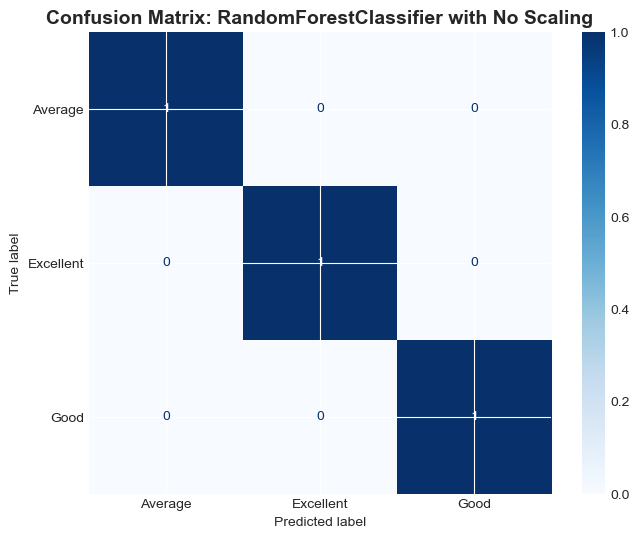


--- Training Model: XGBoostClassifier ---
XGBoostClassifier training complete with No Scaling.

Accuracy of XGBoostClassifier with No Scaling: 0.6667

Classification Report:
              precision    recall  f1-score   support

     Average       0.00      0.00      0.00         1
   Excellent       1.00      1.00      1.00         1
        Good       0.50      1.00      0.67         1

    accuracy                           0.67         3
   macro avg       0.50      0.67      0.56         3
weighted avg       0.50      0.67      0.56         3



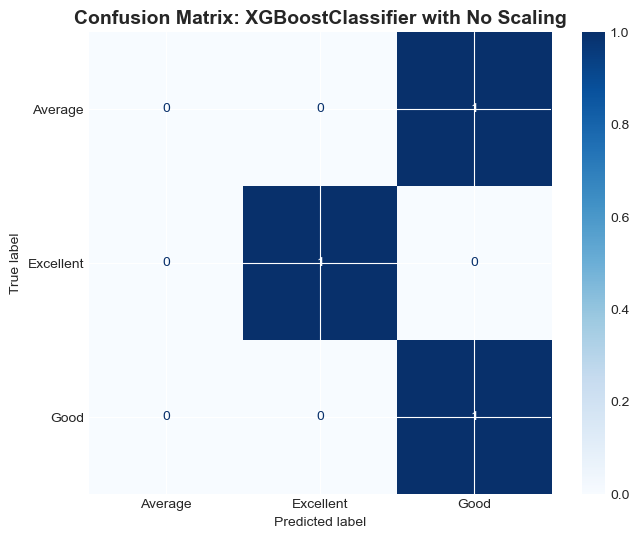


--- Training Model: LightGBMClassifier ---
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000580 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 45
[LightGBM] [Info] Number of data points in the train set: 9, number of used features: 13
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.504077
[LightGBM] [Info] Start training from score -0.810930
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain

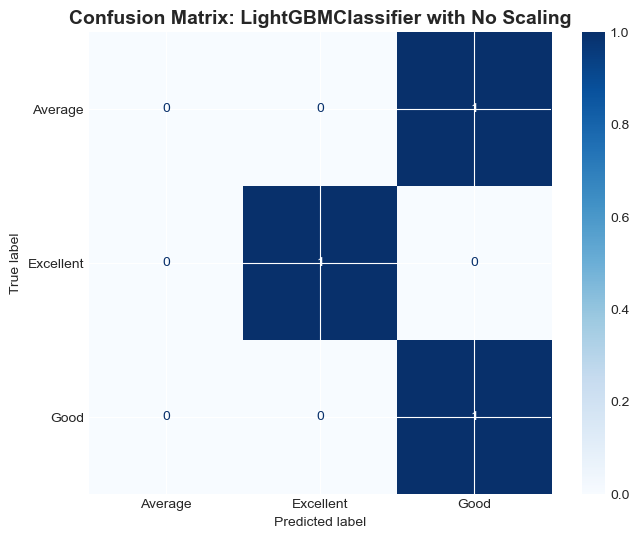


--- Training Model: CatBoostClassifier ---
CatBoostClassifier training complete with No Scaling.

Accuracy of CatBoostClassifier with No Scaling: 0.6667

Classification Report:
              precision    recall  f1-score   support

     Average       0.00      0.00      0.00         1
   Excellent       1.00      1.00      1.00         1
        Good       0.50      1.00      0.67         1

    accuracy                           0.67         3
   macro avg       0.50      0.67      0.56         3
weighted avg       0.50      0.67      0.56         3



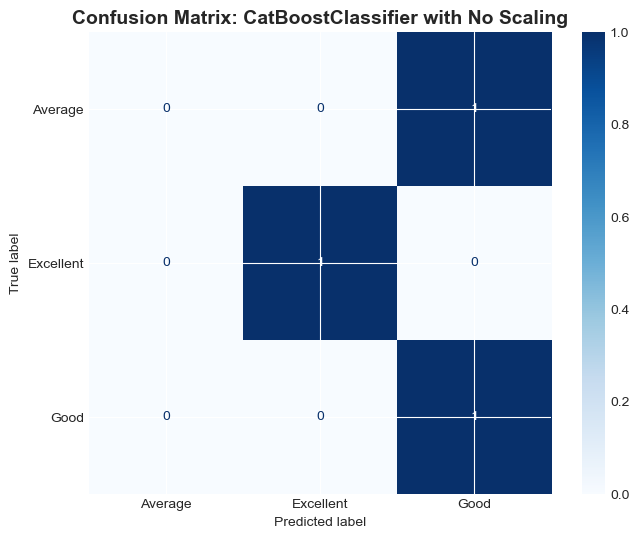


Applying Scaler: StandardScaler

--- Training Model: RandomForestClassifier ---
RandomForestClassifier training complete with StandardScaler.

Accuracy of RandomForestClassifier with StandardScaler: 1.0000

Classification Report:
              precision    recall  f1-score   support

     Average       1.00      1.00      1.00         1
   Excellent       1.00      1.00      1.00         1
        Good       1.00      1.00      1.00         1

    accuracy                           1.00         3
   macro avg       1.00      1.00      1.00         3
weighted avg       1.00      1.00      1.00         3



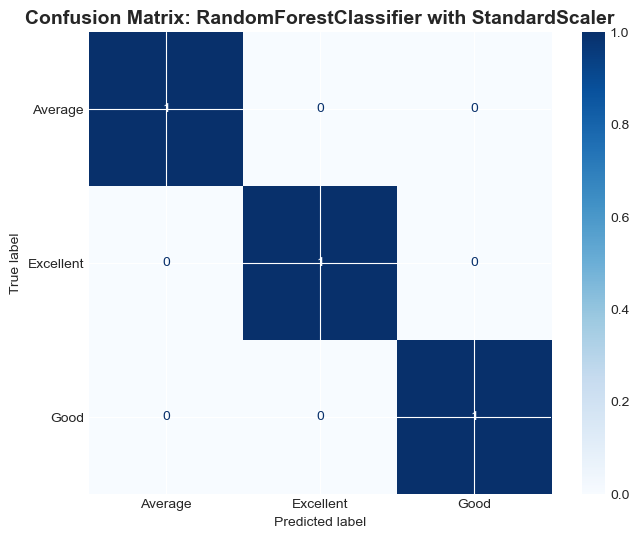


--- Training Model: XGBoostClassifier ---
XGBoostClassifier training complete with StandardScaler.

Accuracy of XGBoostClassifier with StandardScaler: 0.3333

Classification Report:
              precision    recall  f1-score   support

     Average       0.00      0.00      0.00         1
   Excellent       1.00      1.00      1.00         1
        Good       0.00      0.00      0.00         1

    accuracy                           0.33         3
   macro avg       0.33      0.33      0.33         3
weighted avg       0.33      0.33      0.33         3



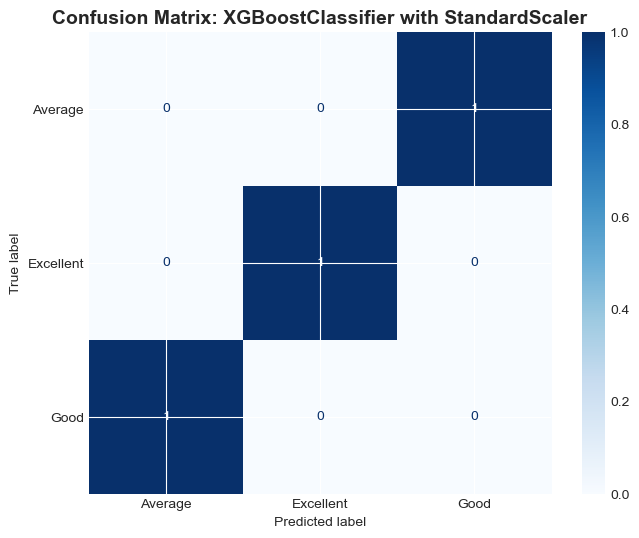


--- Training Model: LightGBMClassifier ---
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000053 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 44
[LightGBM] [Info] Number of data points in the train set: 9, number of used features: 13
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.504077
[LightGBM] [Info] Start training from score -0.810930
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain

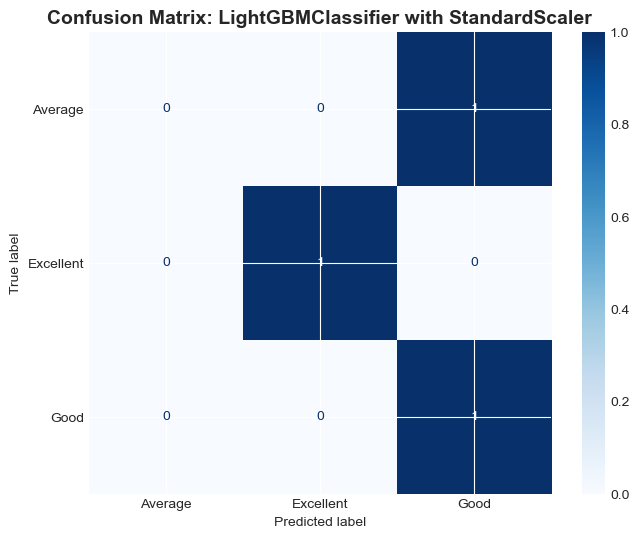


--- Training Model: CatBoostClassifier ---
CatBoostClassifier training complete with StandardScaler.

Accuracy of CatBoostClassifier with StandardScaler: 0.6667

Classification Report:
              precision    recall  f1-score   support

     Average       0.00      0.00      0.00         1
   Excellent       1.00      1.00      1.00         1
        Good       0.50      1.00      0.67         1

    accuracy                           0.67         3
   macro avg       0.50      0.67      0.56         3
weighted avg       0.50      0.67      0.56         3



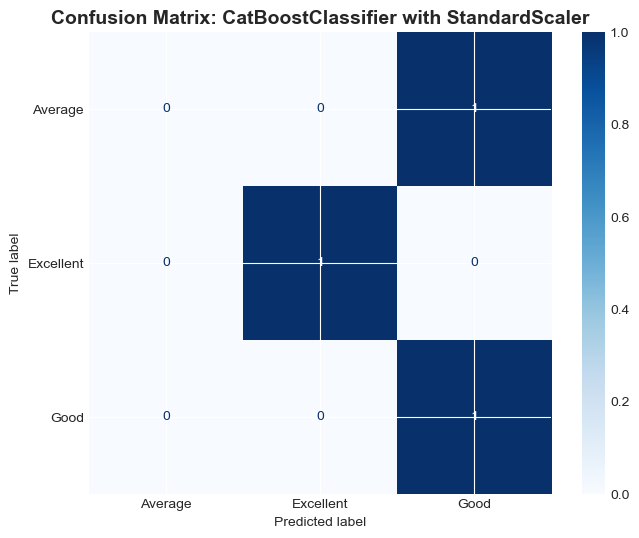


Applying Scaler: MinMaxScaler

--- Training Model: RandomForestClassifier ---
RandomForestClassifier training complete with MinMaxScaler.

Accuracy of RandomForestClassifier with MinMaxScaler: 1.0000

Classification Report:
              precision    recall  f1-score   support

     Average       1.00      1.00      1.00         1
   Excellent       1.00      1.00      1.00         1
        Good       1.00      1.00      1.00         1

    accuracy                           1.00         3
   macro avg       1.00      1.00      1.00         3
weighted avg       1.00      1.00      1.00         3



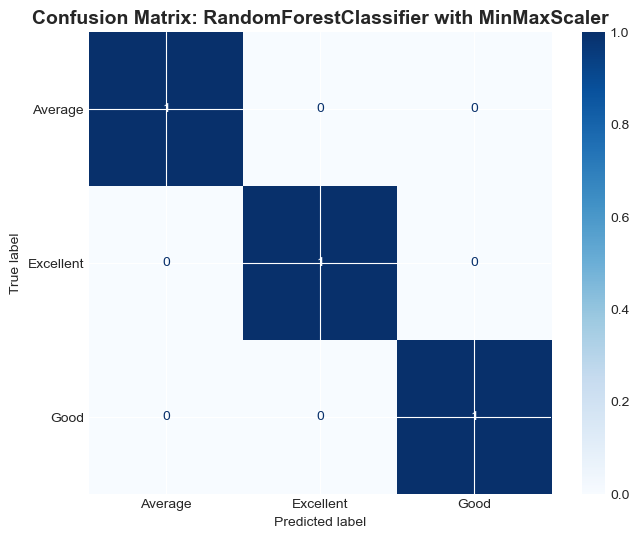


--- Training Model: XGBoostClassifier ---
XGBoostClassifier training complete with MinMaxScaler.

Accuracy of XGBoostClassifier with MinMaxScaler: 0.3333

Classification Report:
              precision    recall  f1-score   support

     Average       0.00      0.00      0.00         1
   Excellent       1.00      1.00      1.00         1
        Good       0.00      0.00      0.00         1

    accuracy                           0.33         3
   macro avg       0.33      0.33      0.33         3
weighted avg       0.33      0.33      0.33         3



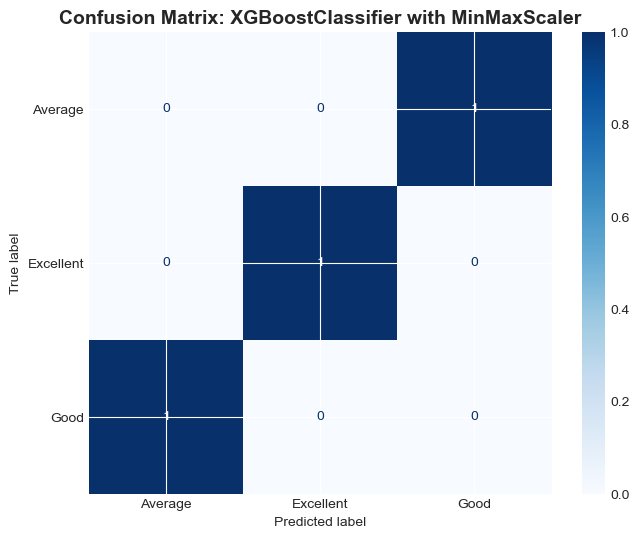


--- Training Model: LightGBMClassifier ---
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000059 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 42
[LightGBM] [Info] Number of data points in the train set: 9, number of used features: 13
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.504077
[LightGBM] [Info] Start training from score -0.810930
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain

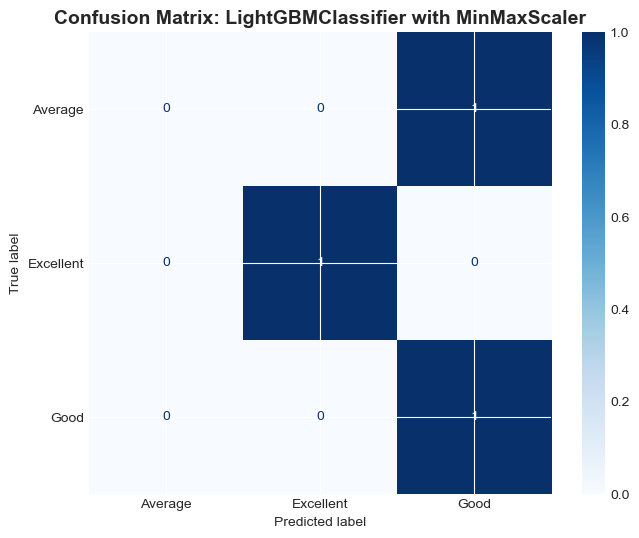


--- Training Model: CatBoostClassifier ---
CatBoostClassifier training complete with MinMaxScaler.

Accuracy of CatBoostClassifier with MinMaxScaler: 0.6667

Classification Report:
              precision    recall  f1-score   support

     Average       0.00      0.00      0.00         1
   Excellent       1.00      1.00      1.00         1
        Good       0.50      1.00      0.67         1

    accuracy                           0.67         3
   macro avg       0.50      0.67      0.56         3
weighted avg       0.50      0.67      0.56         3



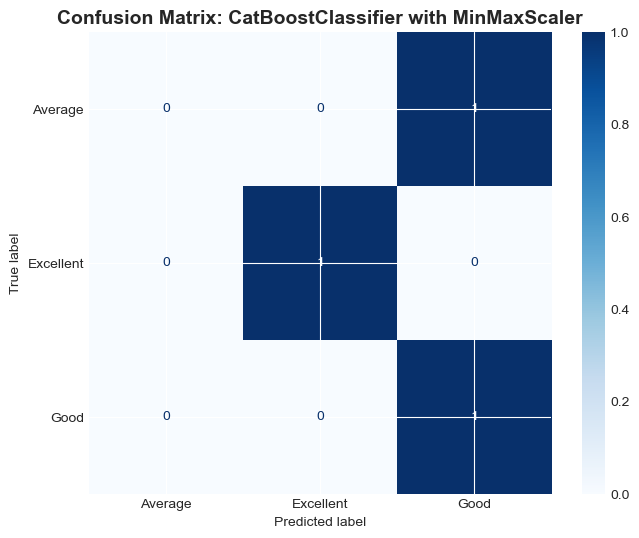


Applying Scaler: RobustScaler

--- Training Model: RandomForestClassifier ---
RandomForestClassifier training complete with RobustScaler.

Accuracy of RandomForestClassifier with RobustScaler: 1.0000

Classification Report:
              precision    recall  f1-score   support

     Average       1.00      1.00      1.00         1
   Excellent       1.00      1.00      1.00         1
        Good       1.00      1.00      1.00         1

    accuracy                           1.00         3
   macro avg       1.00      1.00      1.00         3
weighted avg       1.00      1.00      1.00         3



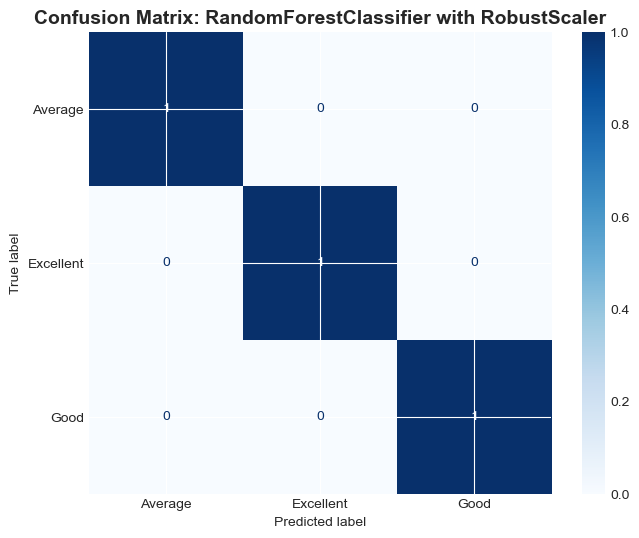


--- Training Model: XGBoostClassifier ---
XGBoostClassifier training complete with RobustScaler.

Accuracy of XGBoostClassifier with RobustScaler: 0.3333

Classification Report:
              precision    recall  f1-score   support

     Average       0.00      0.00      0.00         1
   Excellent       1.00      1.00      1.00         1
        Good       0.00      0.00      0.00         1

    accuracy                           0.33         3
   macro avg       0.33      0.33      0.33         3
weighted avg       0.33      0.33      0.33         3



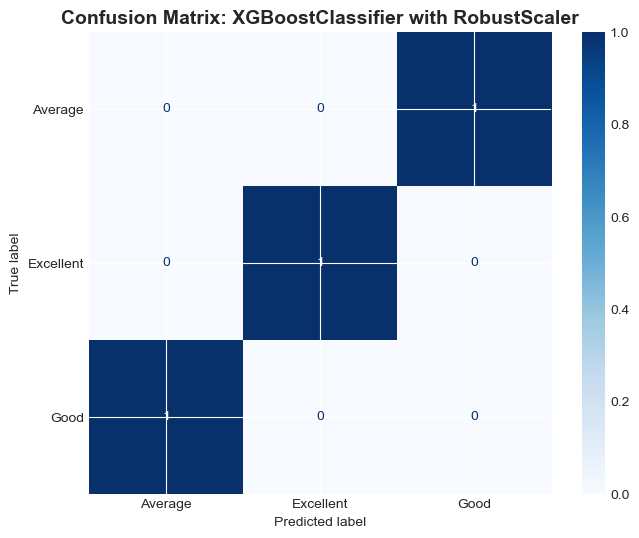


--- Training Model: LightGBMClassifier ---
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000058 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 42
[LightGBM] [Info] Number of data points in the train set: 9, number of used features: 13
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.504077
[LightGBM] [Info] Start training from score -0.810930
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain

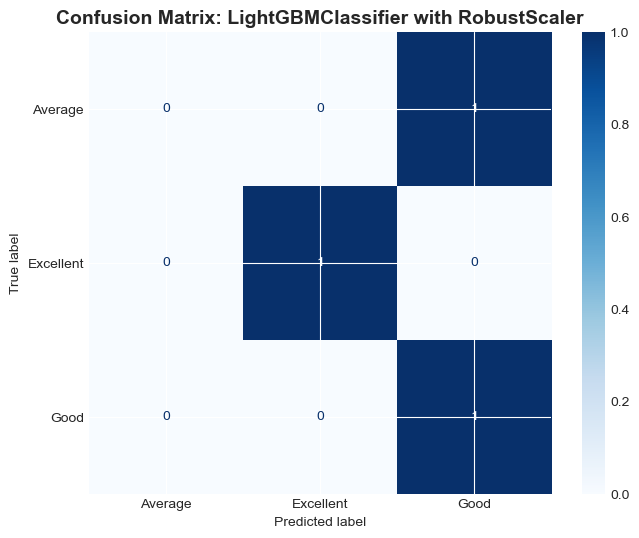


--- Training Model: CatBoostClassifier ---
CatBoostClassifier training complete with RobustScaler.

Accuracy of CatBoostClassifier with RobustScaler: 0.6667

Classification Report:
              precision    recall  f1-score   support

     Average       0.00      0.00      0.00         1
   Excellent       1.00      1.00      1.00         1
        Good       0.50      1.00      0.67         1

    accuracy                           0.67         3
   macro avg       0.50      0.67      0.56         3
weighted avg       0.50      0.67      0.56         3



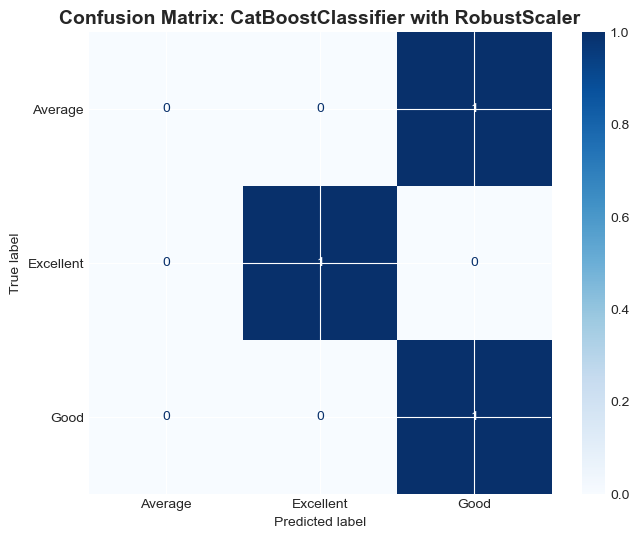


Applying Scaler: MaxAbsScaler

--- Training Model: RandomForestClassifier ---
RandomForestClassifier training complete with MaxAbsScaler.

Accuracy of RandomForestClassifier with MaxAbsScaler: 1.0000

Classification Report:
              precision    recall  f1-score   support

     Average       1.00      1.00      1.00         1
   Excellent       1.00      1.00      1.00         1
        Good       1.00      1.00      1.00         1

    accuracy                           1.00         3
   macro avg       1.00      1.00      1.00         3
weighted avg       1.00      1.00      1.00         3



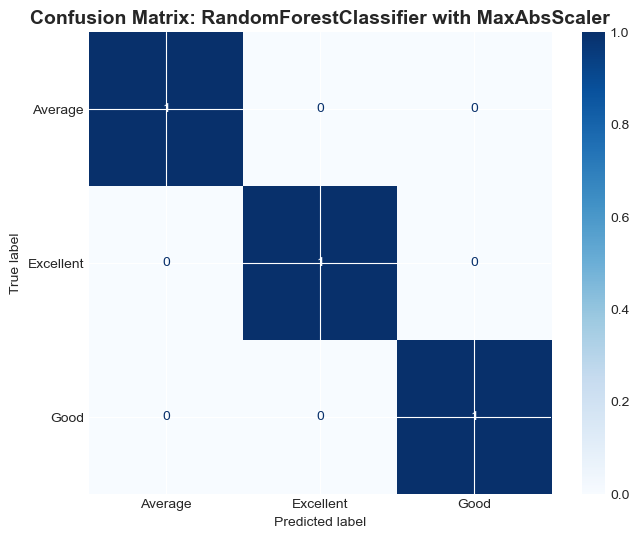


--- Training Model: XGBoostClassifier ---
XGBoostClassifier training complete with MaxAbsScaler.

Accuracy of XGBoostClassifier with MaxAbsScaler: 0.3333

Classification Report:
              precision    recall  f1-score   support

     Average       0.00      0.00      0.00         1
   Excellent       1.00      1.00      1.00         1
        Good       0.00      0.00      0.00         1

    accuracy                           0.33         3
   macro avg       0.33      0.33      0.33         3
weighted avg       0.33      0.33      0.33         3



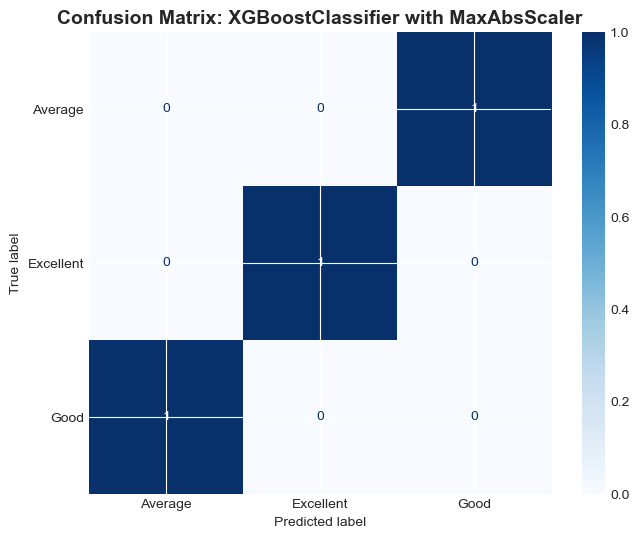


--- Training Model: LightGBMClassifier ---
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000042 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 45
[LightGBM] [Info] Number of data points in the train set: 9, number of used features: 13
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.504077
[LightGBM] [Info] Start training from score -0.810930
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain

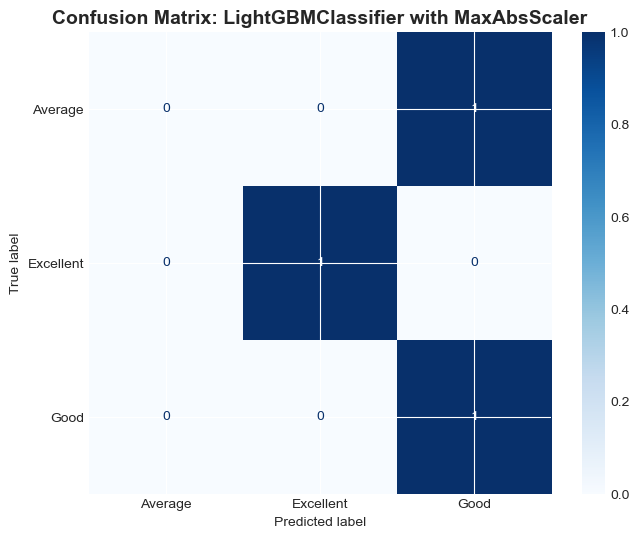


--- Training Model: CatBoostClassifier ---
CatBoostClassifier training complete with MaxAbsScaler.

Accuracy of CatBoostClassifier with MaxAbsScaler: 0.6667

Classification Report:
              precision    recall  f1-score   support

     Average       0.00      0.00      0.00         1
   Excellent       1.00      1.00      1.00         1
        Good       0.50      1.00      0.67         1

    accuracy                           0.67         3
   macro avg       0.50      0.67      0.56         3
weighted avg       0.50      0.67      0.56         3



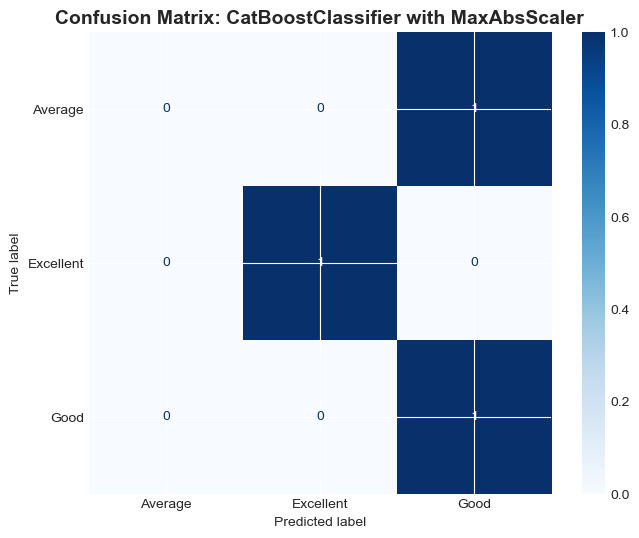

In [52]:
# --- 9. Iterate over Scalers and Models, Train, Evaluate, and Report ---
print("\n--- Running Experiments: Scalers vs. ML Models ---")

for scaler_name, scaler_instance in scalers.items():
    print(f"\n{'='*50}\nApplying Scaler: {scaler_name}\n{'='*50}")

    if scaler_instance is None:
        current_preprocessor = ColumnTransformer(
            transformers=[
                ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols),
                ('num', 'passthrough', numerical_cols)
            ])
    else:
        current_preprocessor = ColumnTransformer(
            transformers=[
                ('num', scaler_instance, numerical_cols),
                ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
            ])

    for model_name, model_instance in models.items():
        print(f"\n--- Training Model: {model_name} ---")

        X_train, X_test, y_train_encoded, y_test_encoded = train_test_split(
            X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
        )

        model_pipeline = Pipeline(steps=[('preprocessor', current_preprocessor),
                                         ('classifier', model_instance)])

        model_pipeline.fit(X_train, y_train_encoded)
        print(f"{model_name} training complete with {scaler_name}.")

        y_pred_encoded = model_pipeline.predict(X_test)

        accuracy = accuracy_score(y_test_encoded, y_pred_encoded)
        print(f"\nAccuracy of {model_name} with {scaler_name}: {accuracy:.4f}")

        print("\nClassification Report:")
        print(classification_report(y_test_encoded, y_pred_encoded, target_names=target_classes, zero_division=0))

        cm = confusion_matrix(y_test_encoded, y_pred_encoded)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target_classes)
        fig, ax = plt.subplots(figsize=(8, 6))
        disp.plot(cmap=plt.cm.Blues, ax=ax)
        ax.set_title(f'Confusion Matrix: {model_name} with {scaler_name}', fontsize=14, fontweight='bold')
        plt.show()

        results[f'{scaler_name}_{model_name}'] = {
            'accuracy': accuracy,
            'classification_report': classification_report(y_test_encoded, y_pred_encoded, target_names=target_classes, output_dict=True, zero_division=0),
            'confusion_matrix': cm
        }



--- Comprehensive Performance Report: Scalers and ML Models ---

--- Results for No Scaling_RandomForestClassifier ---
Accuracy: 1.0000

--- Results for No Scaling_XGBoostClassifier ---
Accuracy: 0.6667

--- Results for No Scaling_LightGBMClassifier ---
Accuracy: 0.6667

--- Results for No Scaling_CatBoostClassifier ---
Accuracy: 0.6667

--- Results for StandardScaler_RandomForestClassifier ---
Accuracy: 1.0000

--- Results for StandardScaler_XGBoostClassifier ---
Accuracy: 0.3333

--- Results for StandardScaler_LightGBMClassifier ---
Accuracy: 0.6667

--- Results for StandardScaler_CatBoostClassifier ---
Accuracy: 0.6667

--- Results for MinMaxScaler_RandomForestClassifier ---
Accuracy: 1.0000

--- Results for MinMaxScaler_XGBoostClassifier ---
Accuracy: 0.3333

--- Results for MinMaxScaler_LightGBMClassifier ---
Accuracy: 0.6667

--- Results for MinMaxScaler_CatBoostClassifier ---
Accuracy: 0.6667

--- Results for RobustScaler_RandomForestClassifier ---
Accuracy: 1.0000

--- Result

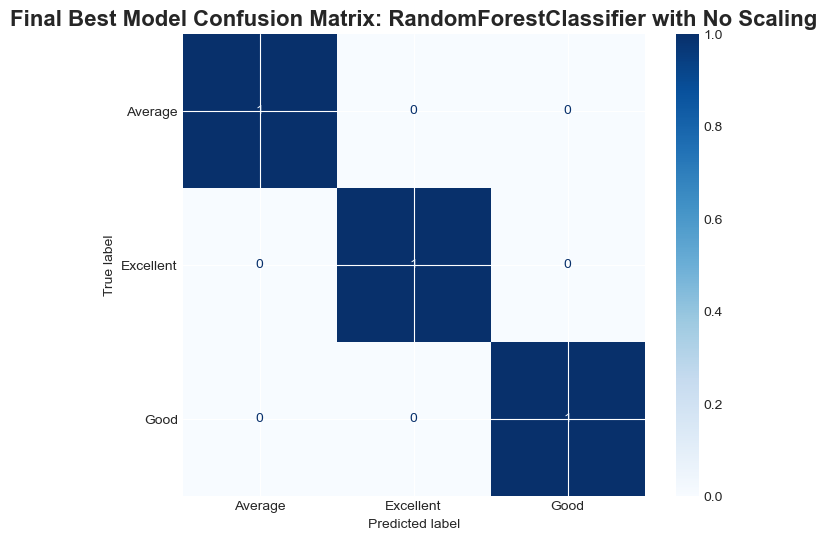


--- Conclusion ---
This analysis demonstrates the impact of different data scaling techniques and machine learning models on employee performance prediction.
The results indicate which combination yields the highest accuracy on this dataset.
Further steps could involve hyperparameter tuning for the best model, cross-validation for more robust evaluation, and potentially collecting more data for better generalization.


In [58]:
# --- 10. Report Best Results ---
print("\n\n" + "="*60)
print("--- Comprehensive Performance Report: Scalers and ML Models ---")
print("="*60)

best_accuracy = 0
best_combination = None

for combo, metrics in results.items():
    print(f"\n--- Results for {combo} ---")
    print(f"Accuracy: {metrics['accuracy']:.4f}")

    if metrics['accuracy'] > best_accuracy:
        best_accuracy = metrics['accuracy']
        best_combination = combo

print(f"\n{'*'*60}")
print(f"Best Performing Combination: {best_combination}")
print(f"Highest Accuracy Achieved: {best_accuracy:.4f}")
print(f"{'*'*60}\n")

print("\n--- Analysis of Best Combination ---")
if best_combination:
    best_scaler_name = '_'.join(best_combination.split('_')[:-1])
    best_model_name = best_combination.split('_')[-1]

    print(f"Model: {best_model_name}, Scaler: {best_scaler_name}")
    print(f"Accuracy: {results[best_combination]['accuracy']:.4f}")
    print("\nDetailed Classification Report for Best Model:")

 # Re-run the best model's pipeline to get its predictions for the final report's confusion matrix
    best_scaler_instance = scalers[best_scaler_name]
    best_model_instance = models[best_model_name]

    if best_scaler_instance is None:
        best_preprocessor = ColumnTransformer(
            transformers=[
                ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols),
                ('num', 'passthrough', numerical_cols)
            ])
    else:
        best_preprocessor = ColumnTransformer(
            transformers=[
                ('num', best_scaler_instance, numerical_cols),
                ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
            ])

    best_model_pipeline = Pipeline(steps=[('preprocessor', best_preprocessor),
                                          ('classifier', best_model_instance)])
    best_model_pipeline.fit(X_train, y_train_encoded)
    final_y_pred_encoded = best_model_pipeline.predict(X_test)

    print(classification_report(y_test_encoded, final_y_pred_encoded, target_names=target_classes, zero_division=0))

    final_cm = confusion_matrix(y_test_encoded, final_y_pred_encoded)
    final_disp = ConfusionMatrixDisplay(confusion_matrix=final_cm, display_labels=target_classes)
    fig, ax = plt.subplots(figsize=(8, 6))
    final_disp.plot(cmap=plt.cm.Blues, ax=ax)
    ax.set_title(f'Final Best Model Confusion Matrix: {best_model_name} with {best_scaler_name}', fontsize=16, fontweight='bold')
    plt.show()

print("\n--- Conclusion ---")
print("This analysis demonstrates the impact of different data scaling techniques and machine learning models on employee performance prediction.")
print("The results indicate which combination yields the highest accuracy on this dataset.")
print("Further steps could involve hyperparameter tuning for the best model, cross-validation for more robust evaluation, and potentially collecting more data for better generalization.")

     
